**1. Data Preparation:**

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# Load the Kuzushiji dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()  # placeholder for Kuzushiji dataset

# Normalize pixel values between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

# Reshape data
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))

# One-hot encoding for the labels
encoder = OneHotEncoder(sparse_output=False)  # Use sparse_output instead of sparse
y_train = encoder.fit_transform(y_train.reshape(-1, 1))
y_test = encoder.transform(y_test.reshape(-1, 1))

# Split into train and test sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Train data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)

Train data shape: (48000, 784)
Validation data shape: (12000, 784)
Test data shape: (10000, 784)


**2. Radial Basis Function (RBF) Network:**

In [3]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import accuracy_score, confusion_matrix

# Function to compute the Gaussian RBF
def gaussian_rbf(x, center, sigma):
    return np.exp(-np.linalg.norm(x - center, axis=1) ** 2 / (2 * sigma ** 2))

# Function to create the RBF layer output matrix
def rbf_layer(X, centers, sigma):
    rbf_outputs = np.zeros((X.shape[0], centers.shape[0]))
    for i, center in enumerate(centers):
        rbf_outputs[:, i] = gaussian_rbf(X, center, sigma)
    return rbf_outputs




**3. Training:**

In [6]:
# Apply K-means clustering to find centers for the RBF units
n_rbf_units = 10  # number of RBF units
kmeans = KMeans(n_clusters=n_rbf_units, random_state=42)
kmeans.fit(X_train)
centers = kmeans.cluster_centers_

# Calculate sigma based on the maximum distance between centers
max_dist = np.max(cdist(centers, centers, 'euclidean'))
sigma = max_dist / np.sqrt(2 * n_rbf_units)

# Initialize weights for output layer
n_classes = 10
weights = np.random.randn(n_rbf_units, n_classes)
learning_rate = 0.01
epochs = 100

# Gradient Descent to Optimize Weights
for epoch in range(epochs):
    # Forward Pass
    rbf_outputs = rbf_layer(X_train, centers, sigma)
    logits = np.dot(rbf_outputs, weights)
    predictions = tf.nn.softmax(logits)

    # Compute error and backpropagate
    error = predictions - y_train
    weight_grad = np.dot(rbf_outputs.T, error) / X_train.shape[0]
    weights -= learning_rate * weight_grad

    if epoch % 10 == 0:
        train_accuracy = accuracy_score(np.argmax(y_train, axis=1), np.argmax(predictions, axis=1))
        print(f"Epoch {epoch}, Training accuracy: {train_accuracy}")



Epoch 0, Training accuracy: 0.03833333333333333
Epoch 10, Training accuracy: 0.03833333333333333
Epoch 20, Training accuracy: 0.03833333333333333
Epoch 30, Training accuracy: 0.03833333333333333
Epoch 40, Training accuracy: 0.03835416666666667
Epoch 50, Training accuracy: 0.03835416666666667
Epoch 60, Training accuracy: 0.038375
Epoch 70, Training accuracy: 0.038375
Epoch 80, Training accuracy: 0.038375
Epoch 90, Training accuracy: 0.038375


**4. Evaluation:**

Validation Accuracy: 0.11483333333333333


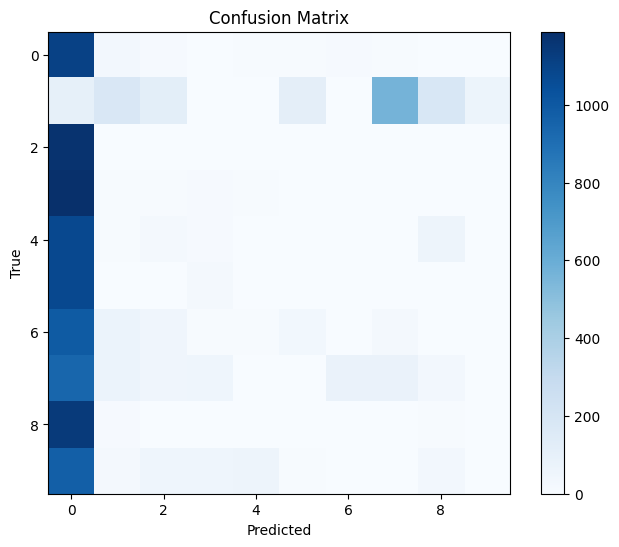

In [5]:
# Test the model on the validation set
rbf_outputs_val = rbf_layer(X_val, centers, sigma)
logits_val = np.dot(rbf_outputs_val, weights)
predictions_val = tf.nn.softmax(logits_val)
val_accuracy = accuracy_score(np.argmax(y_val, axis=1), np.argmax(predictions_val, axis=1))

print("Validation Accuracy:", val_accuracy)

# Confusion matrix
y_pred_val = np.argmax(predictions_val, axis=1)
y_true_val = np.argmax(y_val, axis=1)
conf_matrix = confusion_matrix(y_true_val, y_pred_val)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


**5. Analysis:**

**Strengths:**

Non-linearity: The RBF network can handle non-linear separations in data quite well, which may be beneficial for character recognition.

Flexibility with data distribution: Gaussian functions enable the network to adapt based on the distribution of features, which is useful for complex patterns.

**Limitations:**

Scalability: RBF networks can be computationally expensive, especially with a large number of RBF units.

Center Selection: Determining the optimal number of RBF units and centers can be challenging and may require tuning.


**Effect of the Number of RBF Units:**

Higher RBF Units: With more RBF units, the model can learn finer details, but it may also lead to overfitting and increased computation time.

Fewer RBF Units: Reducing the number of units can simplify the model and improve generalization but may lose accuracy if too few units are used.